In [1]:
import torch
from torch import nn
import numpy as np
import pandas
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (10,6)

pandas.set_option('precision', 20)

import bz2
import pickle
import _pickle as cPickle

In [2]:
# Pickle a file and then compress it into a file with extension 
def compressed_pickle(title, data):
    with bz2.BZ2File(title + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)

# Load any compressed pickle file
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

In [3]:
class Network(nn.Module):
        def __init__(self):
                super().__init__()

                # Layer sizes
                self.input = nn.Linear(6, 100)
                self.first_hidden = nn.Linear(100, 250)
                self.second_hidden = nn.Linear(250, 500)
                self.third_hidden = nn.Linear(500, 250)
                self.fourth_hidden = nn.Linear(250, 100)
                self.fifth_hidden = nn.Linear(100, 50)
                self.output = nn.Linear(50, 1)

                # Activation functions
                self.relu = nn.ReLU()
                self.sigmoid = nn.Sigmoid()

        def forward(self, x:[])->[]:
                x = self.input(x)
                x = self.first_hidden(x)
                x = self.relu(x)
                x = self.second_hidden(x)
                x = self.relu(x)
                x = self.third_hidden(x)
                x = self.relu(x)
                x = self.fourth_hidden(x)
                x = self.relu(x)
                x = self.fifth_hidden(x)
                x = self.relu(x)            
                x = self.output(x)

                return x

In [40]:
dataframe = decompress_pickle('datasets/training_set_08May2022.pbz2')
dataframe

,Theta,Pitch,Duty Cycle,Fill Factor,Mode,Lambda,Transmission
0,5.0,0.00000050,0.4000000000000000222,0.20000000000000001110,0,0.00000170000,0.00009103400000000000
1,5.0,0.00000050,0.4000000000000000222,0.20000000000000001110,0,0.00000169817,0.00010104599999999999
2,5.0,0.00000050,0.4000000000000000222,0.20000000000000001110,0,0.00000169635,0.00011188099999999999
3,5.0,0.00000050,0.4000000000000000222,0.20000000000000001110,0,0.00000169453,0.00012333200000000000
4,5.0,0.00000050,0.4000000000000000222,0.20000000000000001110,0,0.00000169271,0.00013515599999999999
...,...,...,...,...,...,...,...
2240395,11.0,0.00000151,0.4444439999999998947,0.55555600000000004979,1,0.00000131000,-0.00080868699999999999
2240396,11.0,0.00000151,0.4444439999999998947,0.55555600000000004979,1,0.00000130000,-0.00084836399999990003
2240397,11.0,0.00000151,0.4444439999999998947,0.55555600000000004979,1,0.00000130000,-0.00088449199999999996
2240398,11.0,0.00000151,0.4444439999999998947,0.55555600000000004979,1,0.00000130000,-0.00094034800000000003


In [5]:
fill_factor_min = dataframe.min()['Fill Factor']
fill_factor_max = dataframe.max()['Fill Factor']

pitch_min = dataframe.min()['Pitch']
pitch_max = dataframe.max()['Pitch']

theta_min = dataframe.min()['Theta']
theta_max = dataframe.max()['Theta']

duty_cycle_min = dataframe.min()['Duty Cycle']
duty_cycle_max = dataframe.max()['Duty Cycle']

wavelengths = np.linspace(1.3*10**(-6), 1.7*10**(-6), 200)
min_wavelength = min(wavelengths)
max_wavelegnth = max(wavelengths)

transmission_min = dataframe.min()['Transmission']
transmission_max = dataframe.max()['Transmission']

# def get_transmission_val(nn_val)->float:
#     return (nn_val.detach() * (transmission_max - transmission_min) + transmission_min)

In [35]:
# SOME USEFUL FUNCTIONS
def get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength, mode)->torch.tensor:    
    fill_factor = (fill_factor - fill_factor_min)/\
    (fill_factor_max - fill_factor_min)
    
    pitch = (pitch - pitch_min)/(pitch_max - pitch_min)
    
    theta = (theta - theta_min)/(theta_max - theta_min)
    
    duty_cycle = (duty_cycle - duty_cycle_min)/(duty_cycle_max - duty_cycle_min)
    
    wavelength = (wavelength - min_wavelength)/(max_wavelegnth - min_wavelength)
    
    return torch.tensor([theta, pitch, duty_cycle, fill_factor, wavelength, mode], dtype=torch.float32)


def get_transmission_val(nn_val:float)->float:
    inverse = np.power(nn_val.detach().numpy(), -1)
    return np.power(10, -1*inverse)


def get_mean_percentage_error(predicted:np.array, actual:np.array)->float:
    sum = 0
    for i in range(len(predicted)):
        sum = sum + (predicted[i] - actual[i])/actual[i]
    return sum/len(predicted)

In [7]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

device = torch.device("cpu")

In [42]:
# LOAD IN THE TRAINED NETWORKS
GratingCouplerNet = torch.load('models/GratingCouplerNetModel').eval()
GratingCouplerNet.to(device)

Network(
  (input): Linear(in_features=6, out_features=100, bias=True)
  (first_hidden): Linear(in_features=100, out_features=250, bias=True)
  (second_hidden): Linear(in_features=250, out_features=500, bias=True)
  (third_hidden): Linear(in_features=500, out_features=250, bias=True)
  (fourth_hidden): Linear(in_features=250, out_features=100, bias=True)
  (fifth_hidden): Linear(in_features=100, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [41]:
# LOAD IN THE VALIDATION SIMULATIONS
dusan_paper_TM = pandas.read_csv('datasets/validation_examples/TM1.txt')
dusan_paper_TE = pandas.read_csv('datasets/validation_examples/TE1.txt')
# test_TM = pandas.read_csv('TEST_SIMULATIONS/Testing_TM.txt')
# test_TE = pandas.read_csv('TEST_SIMULATIONS/Testing_TE.txt')
# test_TM2 = pandas.read_csv('TEST_SIMULATIONS/Testing_TM_2.txt')
# test_TE2 = pandas.read_csv('TEST_SIMULATIONS/Testing_TE_2.txt')
# test_TM3 = pandas.read_csv('TEST_SIMULATIONS/Testing_TM_3.txt')
# test_TE3 = pandas.read_csv('TEST_SIMULATIONS/Testing_TE_3.txt')
# test_TM5 = pandas.read_csv('TEST_SIMULATIONS/TM5.txt')
# test_TE5 = pandas.read_csv('TEST_SIMULATIONS/TE5.txt')
# test_TM6 = pandas.read_csv('TEST_SIMULATIONS/TM6.txt')
# test_TE6 = pandas.read_csv('TEST_SIMULATIONS/TE6.txt')
# test_TM7 = pandas.read_csv('TEST_SIMULATIONS/TM7.txt')
# test_TE7 = pandas.read_csv('TEST_SIMULATIONS/TE7.txt')
# test_TM8 = pandas.read_csv('TEST_SIMULATIONS/TM8.txt')
# test_TE8 = pandas.read_csv('TEST_SIMULATIONS/TE8.txt')

In [43]:
start_time = time.time()
theta = (14.375)
pitch = (0.75*10**(-6))
duty_cycle = (0.65)
fill_factor = (0.25)
wavelength = np.linspace(1.3*10**(-6), 1.7*10**(-6), 200)

transmission_TM = np.zeros(len(wavelength))
transmission_TE = np.zeros(len(wavelength))

for i in range(len(wavelength)):
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 1)
    transmission_TM[i] = get_transmission_val(GratingCouplerNet(x))
    
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 0)
    transmission_TE[i] = get_transmission_val(GratingCouplerNet(x))
end_time = time.time()
print(end_time-start_time)

0.08018302917480469


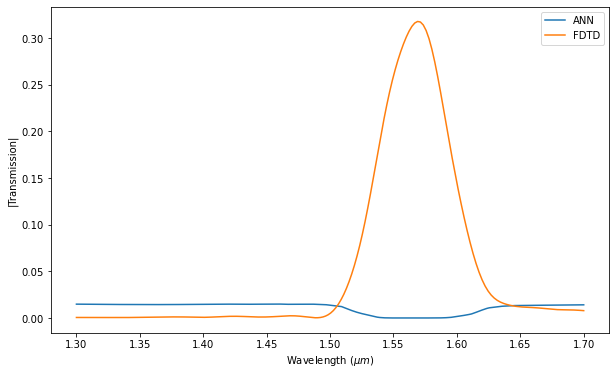

In [44]:
plt.plot(wavelength/10**(-6), np.abs(transmission_TM), label='ANN')
plt.plot(np.flip(dusan_paper_TM['X'])/10**(-6), np.abs(np.flip(dusan_paper_TM['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()
plt.savefig('plots/validation_example_TM_mode')

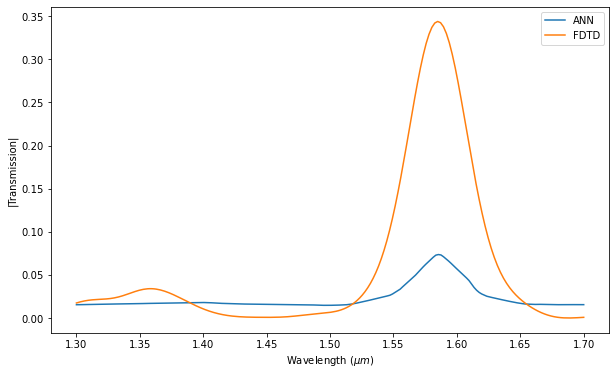

In [39]:
plt.plot(wavelength/10**(-6), transmission_TE, label='ANN')
plt.plot(np.flip(dusan_paper_TE['X'])/10**(-6), np.abs(np.flip(dusan_paper_TE['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()
plt.savefig('plots/validation_example_TE_mode')

In [84]:
# Set up the parameters for a sweep
# Optimize the transmission for the TE mode at 1.55 um
start_time = time.time()
thetas = np.linspace(dataframe.min()['Theta'], dataframe.max()['Theta'], 10)
pitchs = np.linspace(dataframe.min()['Pitch'], dataframe.max()['Pitch'], 10)
duty_cycles = np.linspace(dataframe.min()['Duty Cycle'], dataframe.max()['Duty Cycle'], 10)
fill_factors = np.linspace(dataframe.min()['Fill Factor'], dataframe.max()['Fill Factor'], 10)
mode = 0
wavelength = 1.55*10**(-6)

max_val = 0;
params = [0, 0, 0, 0]
mode = 0
count = 1

for theta in thetas:
    for pitch in pitchs:
        for duty_cycle in duty_cycles:
            for fill_factor in fill_factors:
                x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength, mode)
                if max_val < get_transmission_val(GratingCouplerNet(x)):
                    max_val = get_transmission_val(GratingCouplerNet(x))
                    params[0] = theta
                    params[1] = pitch
                    params[2] = duty_cycle
                    params[3] = fill_factor
                count = count + 1
end_time = time.time()
print(params, max_val)
print(end_time-start_time)

[13.333333333333334, 7.244444444444444e-07, 0.5777777777777778, 0.5111111111111111] [0.40614742]
2.9683890342712402


In [117]:
start_time = time.time()
theta = (13.3333)
pitch = (0.72444444*10**(-6))
duty_cycle = (0.577778)
fill_factor = (0.511111)
wavelength = np.linspace(1.3*10**(-6), 1.7*10**(-6), 200)

transmission_TM = np.zeros(len(wavelength))
transmission_TE = np.zeros(len(wavelength))

for i in range(len(wavelength)):
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 1)
    transmission_TM[i] = np.power(10, five_hidden_layers(x).detach().numpy())
    
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 0)
    transmission_TE[i] = np.power(10, five_hidden_layers(x).detach().numpy())
end_time = time.time()
print(end_time-start_time)

0.14361143112182617


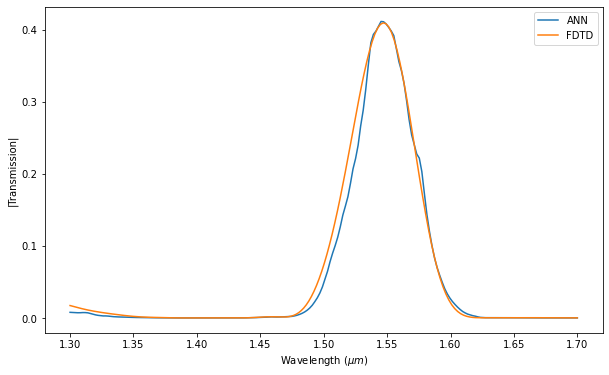

In [118]:
plt.plot(wavelength/10**(-6), transmission_TE, label='ANN')
plt.plot(np.flip(test_TE8['X'])/10**(-6), np.abs(np.flip(test_TE8['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()
plt.savefig('Final Report/OptimizedTransmissionTE.png')

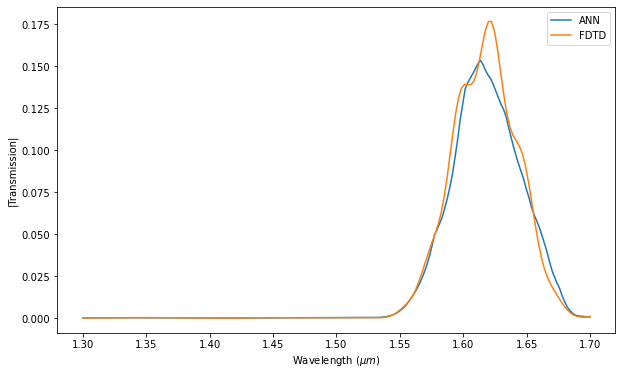

In [119]:
plt.plot(wavelength/10**(-6), transmission_TM, label='ANN')
plt.plot(np.flip(test_TM8['X'])/10**(-6), np.abs(np.flip(test_TM8['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()
plt.savefig('Final Report/OptimizedTransmissionTM.png')

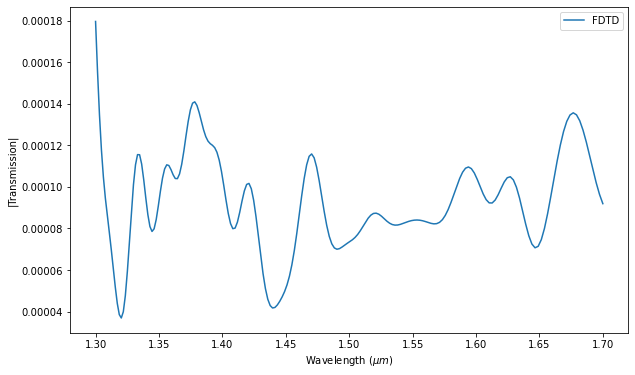

In [116]:
plt.plot(np.flip(test_TM2['X'])/10**(-6), np.abs(np.flip(test_TM2['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()
plt.savefig('Final Report/NoLightCoupled.png')